In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load the data
file_path = 'data/replicate_sugeng_p2p.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


# Extracting the data for each category
access_data = data[['access-bank_office', 'access-atm', 'access-edc', 'access-dfs_agents', 'access-lakupandai_agents']]
usage_data = data[['usage-saving_account', 'usage-loan_account', 'usage-msmes_account', 'usage-debit_transactions', 'usage-credit_transactions', 'usage-emoney', 'usage-emoney_transactions']]
quality_data = data[['quality-complaint_resolved', 'quality-real_interest_rate']]

# Standardize the data
scaler = StandardScaler()
access_data_scaled = scaler.fit_transform(access_data)
usage_data_scaled = scaler.fit_transform(usage_data)
quality_data_scaled = scaler.fit_transform(quality_data)

# Perform PCA for each category
pca_access = PCA(n_components=1)
pca_usage = PCA(n_components=1)
pca_quality = PCA(n_components=1)

access_index = pca_access.fit_transform(access_data_scaled)
usage_index = pca_usage.fit_transform(usage_data_scaled)
quality_index = pca_quality.fit_transform(quality_data_scaled)

# Combine the sub-indices into a DataFrame
sub_indices = pd.DataFrame({
    'access_index': access_index.flatten(),
    'usage_index': usage_index.flatten(),
    'quality_index': quality_index.flatten()
})

sub_indices.head()

,access_index,usage_index,quality_index
0,-3.771186,-2.160193,-0.887301
1,-3.771186,-2.718117,-0.753018
2,-3.728357,-2.677714,-0.753018
3,-3.685527,-2.691204,-0.753018
4,-3.427969,-2.538764,-0.753018


In [2]:
# Perform PCA on the sub-indices to calculate the final FII
pca_fii = PCA(n_components=1)
fii_index = pca_fii.fit_transform(sub_indices)

# Add the FII to the DataFrame
data['FII_with_DFS'] = fii_index.flatten()

data[['months', 'FII_with_DFS']].head()

,months,FII_with_DFS
0,2012-01-01,-4.144338
1,2012-02-01,-4.505145
2,2012-03-01,-4.449850
3,2012-04-01,-4.433626
4,2012-05-01,-4.166735


In [3]:
# Exclude DFS-related indicators from Access and Usage data
access_data_without_dfs = data[['access-bank_office', 'access-lakupandai_agents']]
usage_data_without_dfs = data[['usage-saving_account', 'usage-loan_account', 'usage-msmes_account', 'usage-debit_transactions', 'usage-credit_transactions']]

# Standardize the data
access_data_without_dfs_scaled = scaler.fit_transform(access_data_without_dfs)
usage_data_without_dfs_scaled = scaler.fit_transform(usage_data_without_dfs)

# Perform PCA again without DFS indicators
pca_access_without_dfs = PCA(n_components=1)
pca_usage_without_dfs = PCA(n_components=1)

access_index_without_dfs = pca_access_without_dfs.fit_transform(access_data_without_dfs_scaled)
usage_index_without_dfs = pca_usage_without_dfs.fit_transform(usage_data_without_dfs_scaled)

# Combine the sub-indices without DFS indicators
sub_indices_without_dfs = pd.DataFrame({
    'access_index_without_dfs': access_index_without_dfs.flatten(),
    'usage_index_without_dfs': usage_index_without_dfs.flatten(),
    'quality_index': quality_index.flatten()  # The quality index remains the same
})

# Perform PCA on the sub-indices to calculate the final FII without DFS
pca_fii_without_dfs = PCA(n_components=1)
fii_index_without_dfs = pca_fii_without_dfs.fit_transform(sub_indices_without_dfs)

# Add the FII without DFS to the DataFrame
data['FII_without_DFS'] = fii_index_without_dfs.flatten()

# Display the first few rows with both FII indices
data[['months', 'FII_with_DFS', 'FII_without_DFS']].head()

,months,FII_with_DFS,FII_without_DFS
0,2012-01-01,-4.144338,-3.548079
1,2012-02-01,-4.505145,-3.688654
2,2012-03-01,-4.449850,-3.543240
3,2012-04-01,-4.433626,-3.621065
4,2012-05-01,-4.166735,-3.270787


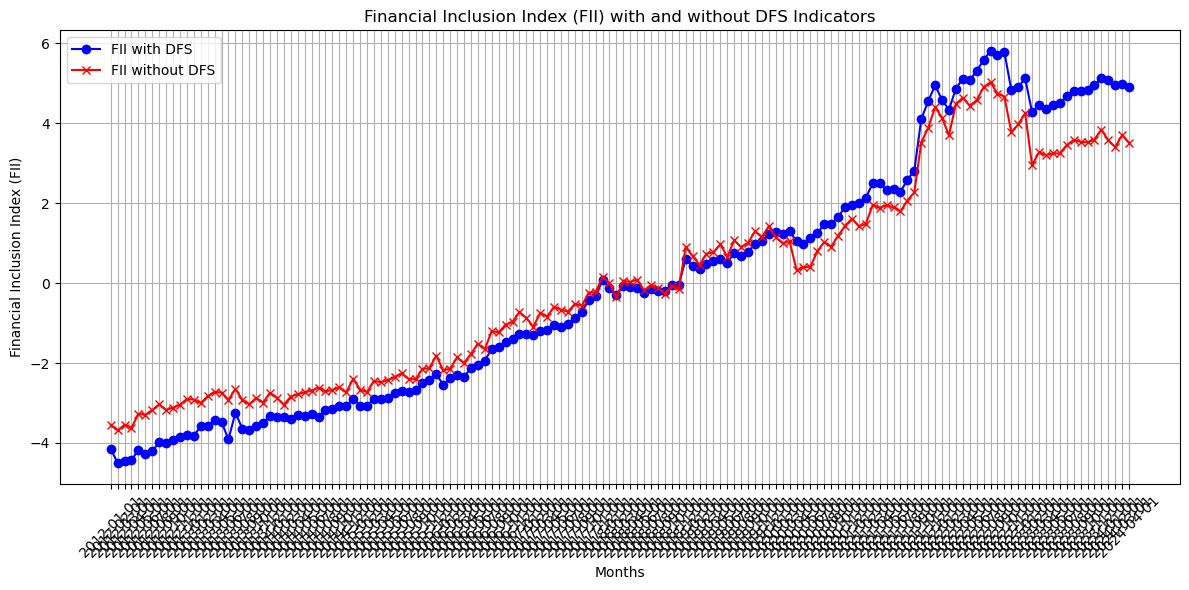

In [4]:
import matplotlib.pyplot as plt

# Plotting the FII with and without DFS over time
plt.figure(figsize=(12, 6))
plt.plot(data['months'], data['FII_with_DFS'], label='FII with DFS', color='blue', marker='o')
plt.plot(data['months'], data['FII_without_DFS'], label='FII without DFS', color='red', marker='x')
plt.xlabel('Months')
plt.ylabel('Financial Inclusion Index (FII)')
plt.title('Financial Inclusion Index (FII) with and without DFS Indicators')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
import numpy as np
def extrapolate(column_name, pre_df):
    pre_df = pre_df.reset_index(drop=True)
    null_idx = pre_df[column_name].isnull().idxmax()
    train_df = pre_df[column_name].iloc[:null_idx]
    
    fit = np.polyfit([x for x in range(0,null_idx)], train_df, 1)
    line = np.poly1d(fit)
    extr = line([x for x in range(null_idx, pre_df.shape[0])])
    
    return list(train_df)+extr.tolist()

# Load the socioeconomic data
control_data_path = 'data/control_socioekonomi.csv'
socio_data_path = 'data/socioekonomi.xlsx'

control_data = pd.read_csv(control_data_path)
control_data['inflation'] = extrapolate('inflation', control_data)
control_data['growth_rate'] = extrapolate('growth_rate', control_data)

socio_data = pd.read_excel(socio_data_path)
socio_data = socio_data.iloc[2:]
socio_data.columns = ["year", "ipm", "poverty_rate", "gini_ratio"]
socio_data = socio_data.astype(float)
socio_data['year'] = socio_data['year'].astype(int)
socio_data['ipm'] = extrapolate('ipm', socio_data)

# Display the first few rows of the datasets
control_data.head(), socio_data.head()

(   year  inflation  growth_rate
 0  2012       4.28         6.03
 1  2013       6.97         5.56
 2  2014       6.42         5.01
 3  2015       6.36         4.88
 4  2016       3.53         5.03,
    year    ipm  poverty_rate  gini_ratio
 2  2012  67.70         11.66       0.413
 3  2013  68.31         11.47       0.406
 4  2014  68.90         10.96       0.414
 5  2015  69.55         11.13       0.402
 6  2016  70.18         10.70       0.394)

In [6]:
# Convert 'months' to datetime format and extract the year
data['months'] = pd.to_datetime(data['months'])
data['year'] = data['months'].dt.year

# Aggregate the FII scores to yearly averages
yearly_fii = data.groupby('year').agg({
    'FII_with_DFS': 'mean',
    'FII_without_DFS': 'mean'
}).reset_index()

# Merge the yearly FII data with the socioeconomic data
merged_data = pd.merge(yearly_fii, socio_data, on='year')
merged_data = pd.merge(merged_data, control_data, on='year')

# Display the merged dataset
merged_data.head()

,year,FII_with_DFS,FII_without_DFS,ipm,poverty_rate,gini_ratio,inflation,growth_rate
0,2012,-4.144856,-3.284495,67.70,11.66,0.413,4.28,6.03
1,2013,-3.561623,-2.862271,68.31,11.47,0.406,6.97,5.56
2,2014,-3.228644,-2.724538,68.90,10.96,0.414,6.42,5.01
3,2015,-2.738577,-2.354543,69.55,11.13,0.402,6.36,4.88
4,2016,-1.922749,-1.524734,70.18,10.70,0.394,3.53,5.03


In [7]:
# Correlation analysis between FII and socioeconomic indicators
correlation_with_dfs = merged_data[['FII_with_DFS', 'gini_ratio', 'poverty_rate', 'ipm']].corr()
correlation_without_dfs = merged_data[['FII_without_DFS', 'gini_ratio', 'poverty_rate', 'ipm']].corr()

correlation_with_dfs, correlation_without_dfs

(              FII_with_DFS  gini_ratio  poverty_rate       ipm
 FII_with_DFS      1.000000   -0.841634     -0.884733  0.981533
 gini_ratio       -0.841634    1.000000      0.914475 -0.880282
 poverty_rate     -0.884733    0.914475      1.000000 -0.916076
 ipm               0.981533   -0.880282     -0.916076  1.000000,
                  FII_without_DFS  gini_ratio  poverty_rate       ipm
 FII_without_DFS         1.000000   -0.859352     -0.893328  0.972023
 gini_ratio             -0.859352    1.000000      0.914475 -0.880282
 poverty_rate           -0.893328    0.914475      1.000000 -0.916076
 ipm                     0.972023   -0.880282     -0.916076  1.000000)

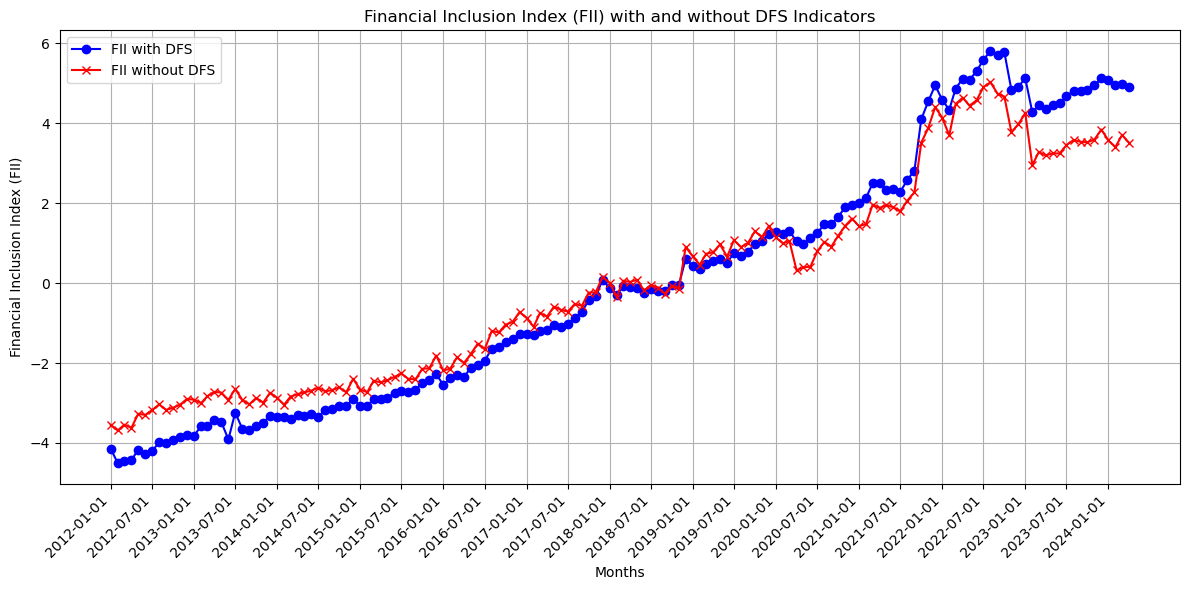

In [9]:
import matplotlib.pyplot as plt

# Plotting the FII with and without DFS over time
plt.figure(figsize=(12, 6))
plt.plot(data['months'], data['FII_with_DFS'], label='FII with DFS', color='blue', marker='o')
plt.plot(data['months'], data['FII_without_DFS'], label='FII without DFS', color='red', marker='x')
plt.xlabel('Months')
plt.ylabel('Financial Inclusion Index (FII)')
plt.title('Financial Inclusion Index (FII) with and without DFS Indicators')
xticks = data['months'][::6]
plt.xticks(xticks, rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import statsmodels.api as sm

# Prepare the independent variables (FII with DFS and control variables)
X_with_dfs = merged_data[['FII_with_DFS', 'inflation', 'growth_rate']]
X_without_dfs = merged_data[['FII_without_DFS', 'inflation', 'growth_rate']]

# Add a constant to the independent variables for the regression
X_with_dfs = sm.add_constant(X_with_dfs)
X_without_dfs = sm.add_constant(X_without_dfs)

# Dependent variables (socioeconomic indicators)
Y_gini = merged_data['gini_ratio']
Y_poverty = merged_data['poverty_rate']
Y_ipm = merged_data['ipm']

# OLS Regression for FII with DFS
model_gini_with_dfs = sm.OLS(Y_gini, X_with_dfs).fit()
model_poverty_with_dfs = sm.OLS(Y_poverty, X_with_dfs).fit()
model_ipm_with_dfs = sm.OLS(Y_ipm, X_with_dfs).fit()

# OLS Regression for FII without DFS
model_gini_without_dfs = sm.OLS(Y_gini, X_without_dfs).fit()
model_poverty_without_dfs = sm.OLS(Y_poverty, X_without_dfs).fit()
model_ipm_without_dfs = sm.OLS(Y_ipm, X_without_dfs).fit()

# Summarize the regression results
model_gini_with_dfs_summary = model_gini_with_dfs.summary()
model_poverty_with_dfs_summary = model_poverty_with_dfs.summary()
model_ipm_with_dfs_summary = model_ipm_with_dfs.summary()

model_gini_without_dfs_summary = model_gini_without_dfs.summary()
model_poverty_without_dfs_summary = model_poverty_without_dfs.summary()
model_ipm_without_dfs_summary = model_ipm_without_dfs.summary()

model_gini_with_dfs_summary, model_poverty_with_dfs_summary, model_ipm_with_dfs_summary, \
model_gini_without_dfs_summary, model_poverty_without_dfs_summary, model_ipm_without_dfs_summary

/Users/adninmp/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/adninmp/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/adninmp/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/adninmp/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/adninmp/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: Use

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:             gini_ratio   R-squared:                       0.811
 Model:                            OLS   Adj. R-squared:                  0.748
 Method:                 Least Squares   F-statistic:                     12.86
 Date:                Sat, 10 Aug 2024   Prob (F-statistic):            0.00132
 Time:                        14:32:23   Log-Likelihood:                 49.744
 No. Observations:                  13   AIC:                            -91.49
 Df Residuals:                       9   BIC:                            -89.23
 Df Model:                           3                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------------------